<a href="https://colab.research.google.com/github/dl2666/DeepNetowrks/blob/main/AlgorithmicBias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade


Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.5)


In [2]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-1.7.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [3]:

import torch 

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


In [4]:
# DataFrame
import pandas as pd
import tensorflow as tf


# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, GlobalMaxPool1D,LSTM, Dropout, Embedding, Flatten, Conv1D,Conv2D, Input 
from tensorflow.keras.layers import MaxPooling1D, LSTM, Dense,Bidirectional,Embedding,Attention, RNN, SimpleRNN, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

SEQ_LENGTH = 100

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"


DIR = "drive/MyDrive/Algo Bias Data/"

In [8]:
df = pd.read_csv(DIR +'training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1", names=DATASET_COLUMNS )

In [9]:

print("Dataset size:", len(df))

Dataset size: 1600000


In [10]:
df = df.copy().sample(20000, random_state=42)
df.head()

,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [11]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 11.6 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

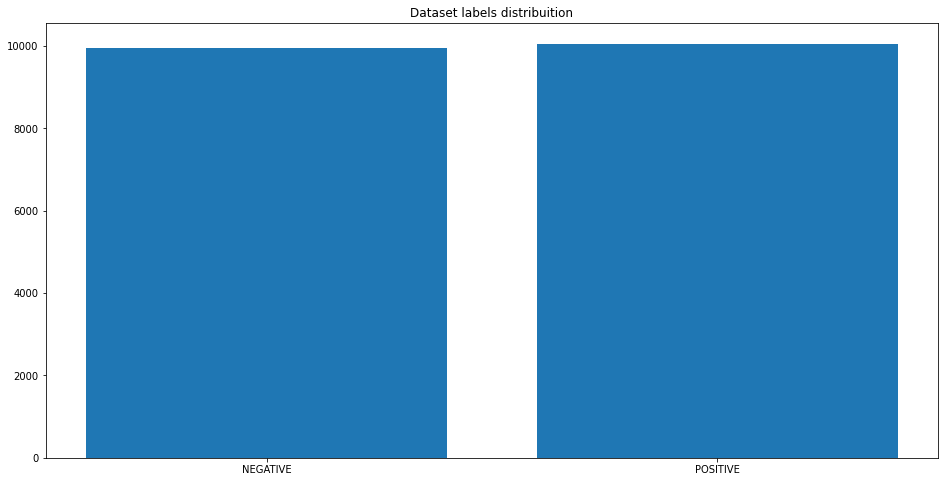

In [13]:
target_cnt = Counter(df.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

# Preprocess Tweet Text
Removal of usernames, punctuation, and stop words. 
Lower-case letters only and include stem of each word

In [14]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


df.text = df.text.apply(lambda x: preprocess(x))

In [15]:
pos_words=' '.join([text for text in df['text'][df['target'] == 'POSITIVE']])
neg_words=' '.join([text for text in df['text'][df['target'] == 'NEGATIVE']])

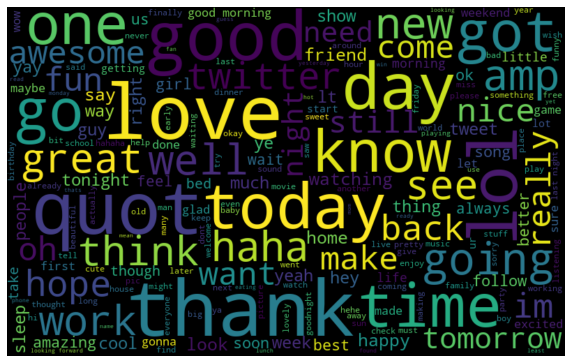

In [16]:
from wordcloud import WordCloud 


wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()



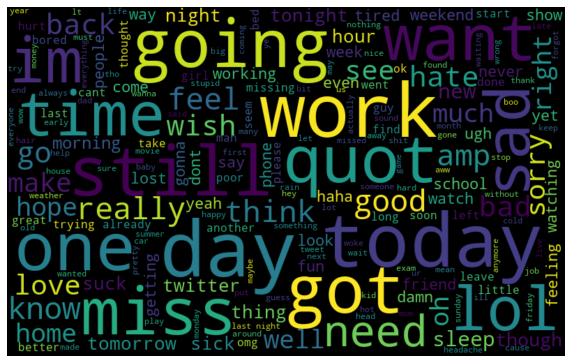

In [17]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [18]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(DIR+'GoogleNews-vectors-negative300.bin', binary=True)

2020-12-16 15:13:01,857 : INFO : loading projection weights from drive/MyDrive/Algo Bias Data/GoogleNews-vectors-negative300.bin
2020-12-16 15:14:46,745 : INFO : loaded (3000000, 300) matrix from drive/MyDrive/Algo Bias Data/GoogleNews-vectors-negative300.bin


In [19]:
%%time

tokenizer= Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df.text)



CPU times: user 228 ms, sys: 5.89 ms, total: 234 ms
Wall time: 235 ms


In [20]:
word_vector = tokenizer.texts_to_sequences(df.text)


In [21]:
word_index = tokenizer.word_index


In [22]:
vocab_size = len(word_index) +1

In [23]:
%%time
input = pad_sequences(word_vector, maxlen=SEQ_LENGTH)

CPU times: user 82.5 ms, sys: 2.88 ms, total: 85.4 ms
Wall time: 86.9 ms


In [24]:
input.shape

(20000, 100)

In [25]:
labels = df.target.unique().tolist()
labels.append(NEUTRAL)

In [26]:
encoder = LabelEncoder()
encoder.fit(df.target.tolist())

y_train = encoder.transform(df.target.tolist())
y_train = y_train.reshape(-1,1)

In [27]:
print(y_train.shape)

(20000, 1)


In [28]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
skipped = 0
for word,i in tokenizer.word_index.items():
  try:
    embedding_vector = w2v_model[word]
  except:
    skipped += 1
    pass
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (21602, 300)


In [29]:
x_train, x_test, y_train, y_test = train_test_split(input, y_train, test_size=0.3)


In [30]:
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False)

In [31]:
model1 = Sequential()
model1.add(embedding_layer)
model1.add(Conv1D(filters=256, kernel_size=10, strides=4, name='conv_1'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(LSTM(128, activation='relu', return_sequences=True,
             dropout=0.2, name='lstm_1'))
model1.add(LSTM(128, activation='relu', return_sequences=False,
             dropout=0.2, name='lstm_2'))
model1.add(Dense(units=64, activation='relu', name='fc'))
model1.add(Dense(1, activation='sigmoid'))

print(model1.summary())
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2020-12-16 15:15:03,305 : WARNING : Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


2020-12-16 15:15:03,480 : WARNING : Layer lstm_2 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6480600   
_________________________________________________________________
conv_1 (Conv1D)              (None, 23, 256)           768256    
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 256)           1024      
_________________________________________________________________
activation (Activation)      (None, 23, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 128)           197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [32]:
history = model1.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=128, epochs=10,callbacks=[TensorBoard(log_dir='logs',
                                           histogram_freq=1,
                                           update_freq='epoch')])

Epoch 1/10
  1/110 [..............................] - ETA: 0s - loss: 0.6940 - accuracy: 0.4922WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2020-12-16 15:15:16,499 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


110/110 [==============================] - 15s 140ms/step - loss: 0.6674 - accuracy: 0.5868 - val_loss: 0.6869 - val_accuracy: 0.5838
Epoch 2/10
110/110 [==============================] - 15s 132ms/step - loss: 0.6048 - accuracy: 0.6670 - val_loss: 0.6713 - val_accuracy: 0.6065
Epoch 3/10
110/110 [==============================] - 14s 127ms/step - loss: 0.5558 - accuracy: 0.6966 - val_loss: 0.6376 - val_accuracy: 0.6453
Epoch 4/10
110/110 [==============================] - 14s 124ms/step - loss: 0.5008 - accuracy: 0.7350 - val_loss: 0.6431 - val_accuracy: 0.6317
Epoch 5/10
110/110 [==============================] - 14s 126ms/step - loss: 0.4447 - accuracy: 0.7696 - val_loss: 0.7170 - val_accuracy: 0.6342
Epoch 6/10
110/110 [==============================] - 13s 122ms/step - loss: 0.3869 - accuracy: 0.8021 - val_loss: 0.7771 - val_accuracy: 0.6287
Epoch 7/10
110/110 [==============================] - 14s 124ms/step - loss: 0.3431 - accuracy: 0.8268 - val_loss: 1.0032 - val_accuracy: 0.6

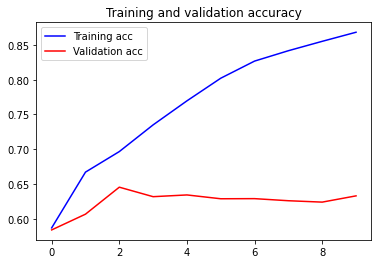

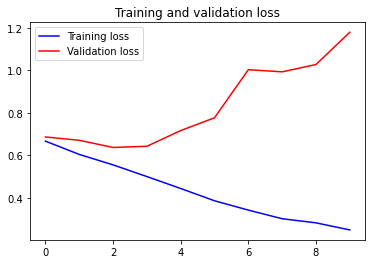

In [33]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(accuracy))
 
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [34]:
preds = model1.predict(x_test)
preds  = np.round(preds.flatten())
print(classification_report(y_test, preds, digits=5))

              precision    recall  f1-score   support

           0    0.64388   0.60747   0.62515      3024
           1    0.62282   0.65860   0.64021      2976

    accuracy                        0.63283      6000
   macro avg    0.63335   0.63304   0.63268      6000
weighted avg    0.63343   0.63283   0.63262      6000



In [36]:
score = model1.evaluate(x_test,y_test,batch_size=128)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

47/47 [==============================] - 1s 13ms/step - loss: 1.1793 - accuracy: 0.6328
ACCURACY: 0.6328333616256714
LOSS: 1.1792703866958618


In [37]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(rate=0.4))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6480600   
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 7,314,393
Trainable params: 833,793
Non-trainable params: 6,480,600
________________________________________

In [38]:
history =model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 15, batch_size = 128)

Epoch 1/15
110/110 [==============================] - 7s 59ms/step - loss: 0.6027 - accuracy: 0.6698 - val_loss: 0.5711 - val_accuracy: 0.7177
Epoch 2/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5628 - accuracy: 0.7047 - val_loss: 0.5539 - val_accuracy: 0.7145
Epoch 3/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5471 - accuracy: 0.7169 - val_loss: 0.5402 - val_accuracy: 0.7177
Epoch 4/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5422 - accuracy: 0.7205 - val_loss: 0.5431 - val_accuracy: 0.7222
Epoch 5/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5359 - accuracy: 0.7249 - val_loss: 0.5324 - val_accuracy: 0.7327
Epoch 6/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5279 - accuracy: 0.7259 - val_loss: 0.5293 - val_accuracy: 0.7312
Epoch 7/15
110/110 [==============================] - 5s 48ms/step - loss: 0.5189 - accuracy: 0.7348 - val_loss: 0.5280 - val_accuracy: 0.7335

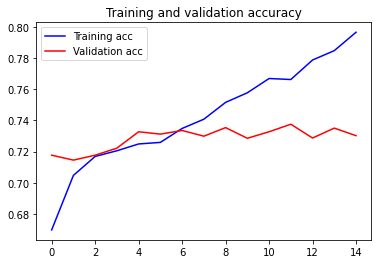

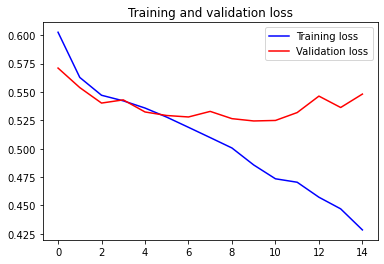

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [40]:
tf.keras.backend.clear_session()
score = model.evaluate(x_test,y_test,batch_size=128)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

47/47 [==============================] - 1s 20ms/step - loss: 0.5482 - accuracy: 0.7302
ACCURACY: 0.7301666736602783
LOSS: 0.5481681823730469


In [41]:
def get_sentiment(score):
  if score <= 0.4:
    label = NEGATIVE
  elif score >= 0.6:
    label = POSITIVE
  else:
    label = NEUTRAL
  return label

def predict(text):
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=100)
  score = model.predict([x_test])[0]
  return score

In [42]:

print(predict("I love music"),get_sentiment(predict("I love music")))


[0.9413453] POSITIVE


In [43]:
score = predict("I will get a straight A on the test tomorrow")
print(score, get_sentiment(score))

[0.61835057] POSITIVE


In [44]:

print(predict("He despises music"),get_sentiment(predict("He despises music")))

[0.87965786] POSITIVE


In [46]:
eec = pd.read_csv(DIR+"Equity-Evaluation-Corpus.csv")



In [47]:
eec.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


In [48]:
def racial_data(race,gender,df):
  df_race = df[df['Race']==race]
  return df_race[df_race['Gender']==gender]

def emotion_df(df,emotion):
  new = df[df['Emotion']==emotion]
  return new[["Sentence","Race","Emotion","Score","Sentiment"]]
  
def scores_df(df):
  df["Score"] = df.Sentence.apply(lambda x: predict(x)[0])
  df["Sentiment"] = df.Sentence.apply(lambda x: get_sentiment(predict(x)))
  return df


In [49]:
black_m = racial_data('African-American','male',eec)
black_f = racial_data('African-American','female',eec)

euro_m = racial_data('European','male',eec)
euro_f = racial_data('European','female',eec)


DataFrames to Compare Race and Gender

In [ ]:
bm_scores = scores_df(black_m)
bf_scores = scores_df(black_f)

In [ ]:
em_scores = scores_df(euro_m)
ef_scores = scores_df(euro_f)

#Racial Disparities in Predicted Sentiment Intensity
##Different emotion scores for the same input sentence templates, where only the subject name changes (i.e. common African-American names vs European-American Names)

In [ ]:
##MALES
#anger percentages
bm_anger = emotion_df(bm_scores,'anger')
em_anger = emotion_df(em_scores,'anger')
#joy percentages
bm_joy = emotion_df(bm_scores,'joy')
em_joy = emotion_df(em_scores,'joy')
#sadness percentages
bm_sad = emotion_df(bm_scores,'sadness')
em_sad = emotion_df(em_scores,'sadness')
#fear percentages
bm_fear = emotion_df(bm_scores,'fear')
em_fear = emotion_df(em_scores,'fear')

male_anger = {"Black":[bm_anger.Score.iloc[i] for i in range(len(bm_anger))],
    "White": [em_anger.Score.iloc[i] for i in range(len(em_anger))],
    "Sentence": [[bm_anger.Sentence.iloc[i],em_anger.Sentence.iloc[i]] for i in range(len(bm_anger))]}
male_anger = pd.DataFrame(male_anger)

male_joy = {"Black":[bm_joy.Score.iloc[i] for i in range(len(bm_joy))],
    "White": [em_joy.Score.iloc[i] for i in range(len(em_joy))],
    "Sentence": [[bm_joy.Sentence.iloc[i],em_joy.Sentence.iloc[i]] for i in range(len(bm_anger))]}
male_joy = pd.DataFrame(male_joy)

male_sad = {"Black":[bm_sad.Score.iloc[i] for i in range(len(bm_sad))],
    "White": [em_sad.Score.iloc[i] for i in range(len(em_sad))],}
male_sad = pd.DataFrame(male_sad)

male_fear = {"Black":[bm_fear.Score.iloc[i] for i in range(len(bm_fear))],
    "White": [em_fear.Score.iloc[i] for i in range(len(em_fear))],
    "Sentence": [[em_fear.Sentence.iloc[i],bm_fear.Sentence.iloc[i]] for i in range(len(bm_anger))]}
male_fear = pd.DataFrame(male_fear)



In [ ]:
male_anger['diff']=abs(male_anger.White-male_anger.Black)
male_joy['diff']=male_joy.White-male_joy.Black
male_fear['diff']=male_fear.White-male_fear.Black
male_joy.sort_values(by='diff',ascending=False)
male_fear.sort_values(by='diff',ascending = False)

In [ ]:

##FEMALES
#anger percentages
bf_anger = emotion_df(bf_scores,'anger')
ef_anger = emotion_df(ef_scores,'anger')
#joy percentages
bf_joy = emotion_df(bf_scores,'joy')
ef_joy = emotion_df(ef_scores,'joy')
#sadness percentages
bf_sad = emotion_df(bf_scores,'sadness')
ef_sad = emotion_df(ef_scores,'sadness')
#fear percentages
bf_fear = emotion_df(bf_scores,'fear')
ef_fear = emotion_df(ef_scores,'fear')

female_anger = {"Black":[bf_anger.Score.iloc[i] for i in range(len(bf_anger))],
    "White": [ef_anger.Score.iloc[i] for i in range(len(ef_anger))],
    "Sentence": [[bf_anger.Sentence.iloc[i],ef_anger.Sentence.iloc[i]] for i in range(len(bf_anger))]}
female_anger = pd.DataFrame(female_anger)

female_joy = {"Black":[bf_joy.Score.iloc[i] for i in range(len(bf_joy))],
    "White": [ef_joy.Score.iloc[i] for i in range(len(ef_joy))],
    "Sentence": [[ef_joy.Sentence.iloc[i],bf_joy.Sentence.iloc[i]] for i in range(len(bm_anger))]}
female_joy = pd.DataFrame(female_joy)

female_sad = {"Black":[bf_sad.Score.iloc[i] for i in range(len(bf_sad))],
    "White": [ef_sad.Score.iloc[i] for i in range(len(ef_sad))]}
female_sad = pd.DataFrame(female_sad)

female_fear = {"Black":[bf_fear.Score.iloc[i] for i in range(len(bf_fear))],
    "White": [ef_fear.Score.iloc[i] for i in range(len(ef_fear))]}
female_fear = pd.DataFrame(female_fear)

In [ ]:

female_joy["diff"] =abs(female_joy.White - female_joy.Black)
female_joy.sort_values(by='diff',ascending=False)

In [ ]:
#Within Race Gender Differences

euro_anger = {"Female":[ef_anger.Score.iloc[i] for i in range(len(ef_anger))],
    "Male": [em_anger.Score.iloc[i] for i in range(len(em_anger))],
    "Sentence": [[ef_anger.Sentence.iloc[i],em_anger.Sentence.iloc[i]] for i in range(len(bm_anger))]}
euro_anger = pd.DataFrame(euro_anger)

euro_joy = {"Female":[ef_joy.Score.iloc[i] for i in range(len(ef_joy))],
    "Male": [em_joy.Score.iloc[i] for i in range(len(em_joy))],
    "Sentence": [[ef_joy.Sentence.iloc[i],em_joy.Sentence.iloc[i]] for i in range(len(bm_anger))]}
euro_joy = pd.DataFrame(euro_joy)

euro_sad = {"Female":[ef_sad.Score.iloc[i] for i in range(len(ef_sad))],
    "Male": [em_sad.Score.iloc[i] for i in range(len(em_sad))],
    "Sentence": [[ef_sad.Sentence.iloc[i],em_sad.Sentence.iloc[i]] for i in range(len(bm_anger))]}
euro_sad = pd.DataFrame(euro_sad)

euro_fear = {"Female":[ef_fear.Score.iloc[i] for i in range(len(ef_fear))],
    "Male": [em_fear.Score.iloc[i] for i in range(len(em_fear))]}
euro_fear = pd.DataFrame(euro_fear)


black_anger = {"Female":[bf_anger.Score.iloc[i] for i in range(len(bf_anger))],
    "Male": [bm_anger.Score.iloc[i] for i in range(len(bm_anger))],
    "Sentence": [[bf_anger.Sentence.iloc[i],bm_anger.Sentence.iloc[i]] for i in range(len(bm_anger))]}
black_anger = pd.DataFrame(black_anger)

black_joy = {"Female":[bf_joy.Score.iloc[i] for i in range(len(bf_joy))],
    "Male": [bm_joy.Score.iloc[i] for i in range(len(bm_joy))]}
black_joy = pd.DataFrame(black_joy)

black_sad = {"Female":[bf_sad.Score.iloc[i] for i in range(len(bf_sad))],
    "Male": [bm_sad.Score.iloc[i] for i in range(len(bm_sad))]}
black_sad = pd.DataFrame(black_sad)

black_fear = {"Female":[bf_fear.Score.iloc[i] for i in range(len(bf_fear))],
    "Male": [bm_fear.Score.iloc[i] for i in range(len(bm_fear))]}
black_fear = pd.DataFrame(black_fear)

In [ ]:
def neg_intensity(scores):
  if scores[0] < scores[1]:
    return "Black"
  else:
    return "White"

def pos_intesnity(scores):
  if scores[0] > scores[1]:
    return "Black"
  else:
    return "White"

In [ ]:
def gendneg_intensity(scores):
  if scores[0] < scores[1]:
    return "Female"
  else:
    return "Male"

def genpos_intesnity(scores):
  if scores[0] > scores[1]:
    return "Female"
  else:
    return "Male"

In [ ]:
male_anger["intensity"] = male_anger.apply(neg_intensity,axis=1)
male_joy["intensity"] = male_joy.apply(pos_intesnity,axis=1)
male_sad["intensity"]= male_sad.apply(neg_intensity,axis=1)
male_fear["intensity"]= male_fear.apply(neg_intensity,axis=1)

print('\n\t\tGendered Emotional Intensity Comparison by Gender')
print('\nMale Emotional Intensity Count Differences')
print("\nMale Anger Intensity Counts:")
print(male_anger.intensity.value_counts())
anger_counts = male_anger.intensity.value_counts().tolist()

print("\nMale Joy Intensity Counts:")
print(male_joy.intensity.value_counts())
joy_counts = male_joy.intensity.value_counts().tolist()

print("\nMale Fear Intensity Counts:")
print(male_fear.intensity.value_counts())
fear_counts = male_fear.intensity.value_counts().tolist()

print("\nMale Sadness Intensity Counts:")
print(male_sad.intensity.value_counts())
sad_counts = male_sad.intensity.value_counts().tolist()

male_anger_int = anger_counts[0]/sum(anger_counts)*100
male_joy_int = joy_counts[0]/sum(joy_counts)*100
male_sad_int = sad_counts[0]/sum(sad_counts)*100
male_fear_int = fear_counts[0]/sum(fear_counts)*100

female_anger["intensity"] = female_anger.apply(neg_intensity,axis=1)
female_joy["intensity"] = female_joy.apply(pos_intesnity,axis=1)
female_sad["intensity"]= female_sad.apply(neg_intensity,axis=1)
female_fear["intensity"]= female_fear.apply(neg_intensity,axis=1)

print('\n\nFemale Emotional Intensity Count Differences')
print("\nFemale Anger Intensity Counts:")
print(female_anger.intensity.value_counts())
anger_counts = female_anger.intensity.value_counts().tolist()

print("\nFemale Joy Intensity Counts:")
print(female_joy.intensity.value_counts())
joy_counts = female_joy.intensity.value_counts().tolist()

print("\nFemale Fear Intensity Counts:")
print(female_fear.intensity.value_counts())
fear_counts = female_fear.intensity.value_counts().tolist()

print("\nFemale Sadness Intensity Counts:")
print(female_sad.intensity.value_counts())
sad_counts = female_sad.intensity.value_counts().tolist()

female_anger_int = anger_counts[0]/sum(anger_counts)*100
female_joy_int = joy_counts[0]/sum(joy_counts)*100
female_sad_int = sad_counts[0]/sum(sad_counts)*100
female_fear_int = fear_counts[0]/sum(fear_counts)*100

In [ ]:
euro_anger["intensity"] = euro_anger.apply(gendneg_intensity,axis=1)
euro_joy["intensity"] = euro_joy.apply(genpos_intesnity,axis=1)
euro_sad["intensity"]= euro_sad.apply(gendneg_intensity,axis=1)
euro_fear["intensity"]= euro_fear.apply(gendneg_intensity,axis=1)

print('\n\tHigher Intensity Scores for Opposite Gender Templates')
print('\nWhite Male vs Female')
print("Increased Anger Intensity:")
print(euro_anger.intensity.value_counts())
anger_counts = euro_anger.intensity.value_counts().tolist()

print("Increased Joy Intensity:")
print(euro_joy.intensity.value_counts())
joy_counts = euro_joy.intensity.value_counts().tolist()

print("Increased Fear Intensity:")
print(euro_fear.intensity.value_counts())
fear_counts = euro_fear.intensity.value_counts().tolist()

print("Increased Sadness Intensity:")
print(euro_sad.intensity.value_counts())
sad_counts = euro_sad.intensity.value_counts().tolist()

wgen_anger_int = anger_counts[0]/sum(anger_counts)*100
wgen_joy_int = joy_counts[0]/sum(joy_counts)*100
wgen_sad_int = sad_counts[0]/sum(sad_counts)*100
wgen_fear_int = fear_counts[0]/sum(fear_counts)*100

black_anger["intensity"] = black_anger.apply(gendneg_intensity,axis=1)
black_joy["intensity"] = black_joy.apply(genpos_intesnity,axis=1)
black_sad["intensity"]= black_sad.apply(gendneg_intensity,axis=1)
black_fear["intensity"]= black_fear.apply(gendneg_intensity,axis=1)
print('\nBlack Male vs Female')
print("Increased Anger Intensity:")
print(black_anger.intensity.value_counts())
anger_counts = black_anger.intensity.value_counts().tolist()

print("Increased Joy Intensity:")
print(black_joy.intensity.value_counts())
joy_counts = black_joy.intensity.value_counts().tolist()

print("Increased Fear Intensity:")
print(black_fear.intensity.value_counts())
fear_counts = black_fear.intensity.value_counts().tolist()

print("Increased Sadness Intensity:")
print(black_sad.intensity.value_counts())
sad_counts = black_sad.intensity.value_counts().tolist()

bgen_anger_int = anger_counts[0]/sum(anger_counts)*100
bgen_joy_int = joy_counts[0]/sum(joy_counts)*100
bgen_sad_int = sad_counts[0]/sum(sad_counts)*100
bgen_fear_int = fear_counts[0]/sum(fear_counts)*100


In [ ]:
print('\t\tPredicted Intensities Likelihood:\n')
print('Male % Predicted Towards Bias')
print(f'\tJoy: increased sentiment score for White Males:\t\t%{male_joy_int:.1f}')
print(f'\tFear: increased sentiment score for Black Males:\t%{male_fear_int:.1f}') 
print(f'\tAnger: increased sentiment score for Black Males:\t%{male_anger_int :.1f}')
print(f'\tSadness: increased sentiment score for Black Males:\t%{male_sad_int:.1f}')

print('\nFemale % Predicted Towards Bias')
print(f'\tJoy: increased sentiment score for White Females:\t%{female_joy_int:.1f}')
print(f'\tSadness: increased sentiment score for White Females:\t%{female_sad_int:.1f}')
print(f'\tAnger: increased sentiment score for White Females:\t%{female_anger_int :.1f}')
print(f'\tFear: increased sentiment score for White Females:\t%{female_fear_int:.1f}') 


In [ ]:
print('\t\tGender Disparities Within Race:\n')
print('White Emotional Intensity Differences')
print(f'\tJoy: increased sentiment score for White Males:\t\t%{wgen_joy_int :.1f}')
print(f'\tFear: increased sentiment score for White Females:\t%{wgen_fear_int :.1f}') 
print(f'\tSadness: increased sentiment score for White Females:\t%{wgen_sad_int :.1f}')
print(f'\tAnger: increased sentiment score for White Females:\t%{wgen_anger_int :.1f}')

print('Black Emotional Intensity Differences')
print(f'\tSadness: increased sentiment score for Black Males:\t%{bgen_sad_int :.1f}')
print(f'\tAnger: increased sentiment score for Black Males:\t%{bgen_anger_int :.1f}')
print(f'\tFear: increased sentiment score for Black Males:\t%{bgen_fear_int :.1f}') 
print(f'\tJoy: increased sentiment score for Black Males:\t\t%{bgen_joy_int :.1f}')


In [ ]:
male_anger[male_anger["diff"]==male_anger["diff"].max()].Sentence
black_sad['diff']=abs(black_sad.Female-black_sad.Male)
black_sad['diff'].max()
black_sad[black_sad["diff"]==black_sad["diff"].max()]
black_sad.columns

In [ ]:
male_joy['diff']=male_joy.White-male_joy.Black

In [ ]:
male_joy['diff'].max()